In [4]:
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import joblib


In [5]:
# Function to extract audio features
def extract_features(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr, mono=True)  # MP3 support
    
    # Time-Domain Features
    rms = librosa.feature.rms(y=y).mean()
    zcr = librosa.feature.zero_crossing_rate(y).mean()
    
    # Pitch-Based Features
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    
    # Frequency-Domain Features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    
    # Energy-Based Features
    sub_band_energy = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    return np.hstack([rms, zcr, pitch_mean, spectral_centroid, spectral_bandwidth, sub_band_energy, mfccs_mean])

In [6]:
X = []
y = []

audio_folder = r'D:\DATASETS'  # Change this to your actual path
labels = {"action": 0, "comedy": 1, "drama": 2, "horror": 3, "musical": 4, "noise": 5}  # Example labels

# Collect all files for progress bar
all_files = []
for genre in labels:
    genre_folder = os.path.join(audio_folder, genre)
    all_files.extend([os.path.join(genre_folder, f) for f in os.listdir(genre_folder) if f.endswith(".mp3")])

# Process files with progress bar
for file_path in tqdm(all_files, desc="Extracting Features"):
    genre = os.path.basename(os.path.dirname(file_path))  # Get genre name from folder
    features = extract_features(file_path)  # Extract features
    X.append(features)  # Store extracted features
    y.append(labels[genre])  # Store corresponding label

X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save the scaler for future use
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as 'scaler.pkl'")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Extracting Features: 100%|██████████| 5500/5500 [2:55:57<00:00,  1.92s/it]  

Scaler saved as 'scaler.pkl'


In [7]:
print(type(y_train))
print(y_train.shape)  # If y_train is loaded correctly, it should show its shape


<class 'numpy.ndarray'>
(4400,)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

learning_rate = 0.0005 
l2_lambda = 0.0030    
model = Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)),
    layers.Dropout(0.35),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)),
    layers.Dropout(0.35),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),
    layers.Dropout(0.35),  # Extra dropout to match the research paper
    layers.Dense(6, activation='softmax', kernel_regularizer=l2(l2_lambda))
])


optimizer = Adam(learning_rate=learning_rate) 

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
results = model.fit(X_train, y_train, epochs=40, batch_size=32, shuffle=True, validation_data=(X_test, y_test))
model.save("baselinemodel.h5")

Epoch 1/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3353 - loss: 2.4776 - val_accuracy: 0.5818 - val_loss: 1.8679
Epoch 2/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5543 - loss: 1.8981 - val_accuracy: 0.6182 - val_loss: 1.6389
Epoch 3/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5963 - loss: 1.6959 - val_accuracy: 0.6436 - val_loss: 1.4981
Epoch 4/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6425 - loss: 1.5451 - val_accuracy: 0.6682 - val_loss: 1.3912
Epoch 5/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6598 - loss: 1.4461 - val_accuracy: 0.6945 - val_loss: 1.3000
Epoch 6/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6787 - loss: 1.3378 - val_accuracy: 0.7073 - val_loss: 1.2253
Epoch 7/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6801 - loss: 1.2765 - val_accuracy: 0.7273 - val_loss: 1.1767
Epoch 8/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6793 - loss: 1.2321 - val_accuracy: 0.

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7437 - loss: 0.8861
Test Accuracy: 74.00%


In [19]:
# Assuming you have test data (X_test) and true labels (y_true)
y_pred_prob = model.predict(X_test)  # Generate predictions (probabilities)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Classification report
report = classification_report(y_test, y_pred, target_names=["Action", "Comedy", "Drama", "Horror", "Musical", "Noise"])
print(report)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

      Action       0.81      0.89      0.85       214
      Comedy       0.71      0.75      0.73       208
       Drama       0.69      0.62      0.65       199
      Horror       0.54      0.47      0.50       178
     Musical       0.80      0.83      0.82       199
       Noise       0.93      0.90      0.92       102

    accuracy                           0.74      1100
   macro avg       0.75      0.75      0.74      1100
weighted avg       0.73      0.74      0.74      1100



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


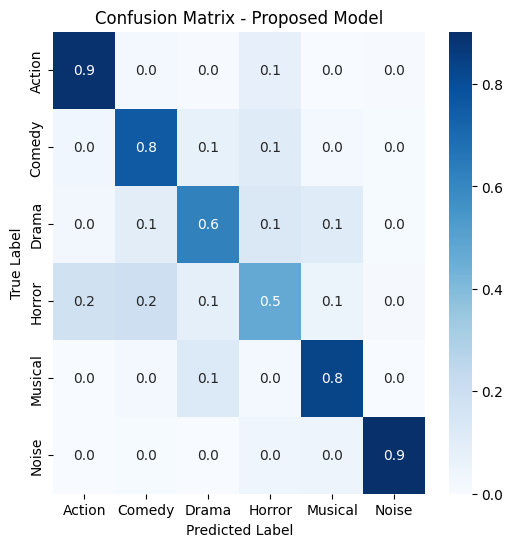

In [20]:
# Replace these with your actual test labels and predictions
y_test  # Ensure this is a NumPy array or list of labels

y_pred_proposed = np.argmax(model.predict(X_test), axis=1)

# Define class labels (adjust based on your dataset)
labels = ["Action", "Comedy", "Drama", "Horror", "Musical", "Noise"]

# Compute and plot confusion matrix for Proposed Model
cm = confusion_matrix(y_test, y_pred_proposed, normalize="true")
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Proposed Model")
plt.show()

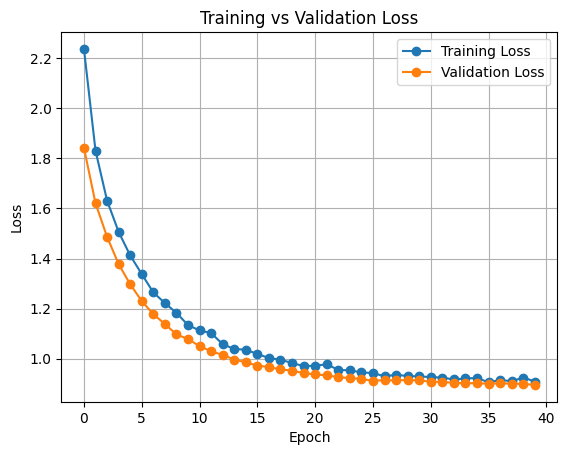

In [21]:
plt.plot(results.history['loss'], marker='o', label='Training Loss')
plt.plot(results.history['val_loss'], marker='o', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

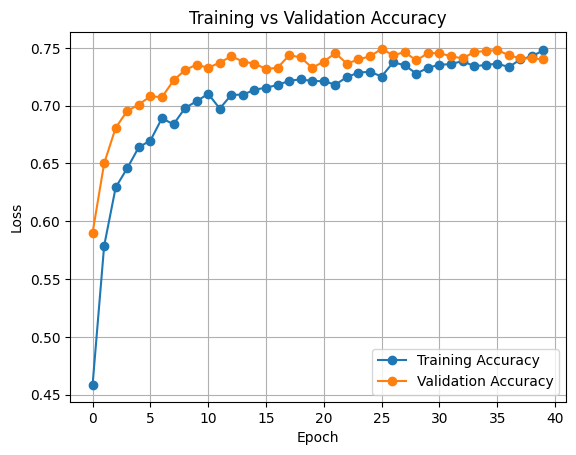

In [22]:
# Assuming 'history' is the object returned from model.fit()
plt.plot(results.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(results.history['val_accuracy'], marker='o', label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()